In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-06-21 14:00:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-06-21 14:00:00 (6.13 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



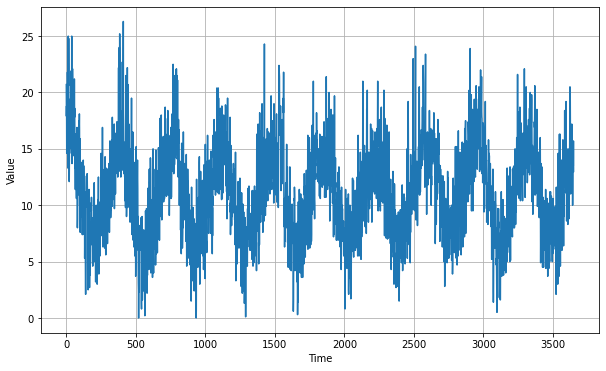

In [11]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  data = csv.reader(csvfile,delimiter=',')
  next(data,None)
  step=0
  for col in data:
    temps.append(float(col[1]))
    time_step.append(step)
    step+=1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [12]:
split_time = 2500
time_train = time[:2500]
x_train = series[:2500]
time_valid = time[2500:]
x_valid = series[2500:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series,axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1,shift=1,drop_remainder=True)
    data = data.flat_map(lambda x: x.batch(window_size+1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda x: (x[:-1],x[1:]))
    
    return data.batch(batch_size).prefetch(1)

In [20]:
def model_forecast(model, series, window_size):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size,shift=1,drop_remainder=True)
    data = data.flat_map(lambda x: x.batch(window_size+1))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)

    return forecast

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 48ms/step - loss: 16.9066 - mae: 17.4036 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 46ms/step - loss: 16.5037 - mae: 17.0007 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 50ms/step - loss: 15.9662 - mae: 16.4629 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 52ms/step - loss: 15.4110 - mae: 15.9076 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 51ms/step - loss: 14.8722 - mae: 15.3684 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 51ms/step - loss: 14.3523 - mae: 14.8480 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 50ms/step - loss: 13.8329 - mae: 14.3284 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 52ms/step - loss: 13.2974 - mae: 13.7922 - l

(1e-08, 0.0001, 0.0, 60.0)

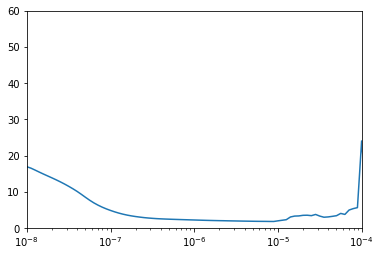

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 1s 31ms/step - loss: 4.1908 - mae: 4.6590
Epoch 2/150
25/25 [==============================] - 1s 34ms/step - loss: 2.0866 - mae: 2.5446
Epoch 3/150
25/25 [==============================] - 1s 31ms/step - loss: 1.9015 - mae: 2.3551
Epoch 4/150
25/25 [==============================] - 1s 31ms/step - loss: 1.8333 - mae: 2.2848
Epoch 5/150
25/25 [==============================] - 1s 33ms/step - loss: 1.7865 - mae: 2.2368
Epoch 6/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7965 - mae: 2.2479
Epoch 7/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7944 - mae: 2.2454
Epoch 8/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7226 - mae: 2.1712
Epoch 9/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7187 - mae: 2.1670
Epoch 10/150
25/25 [==============================] - 1s 31ms/step - loss: 1.7700 - mae: 2.2206
Epoch 11/150
25/25 [=============================

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

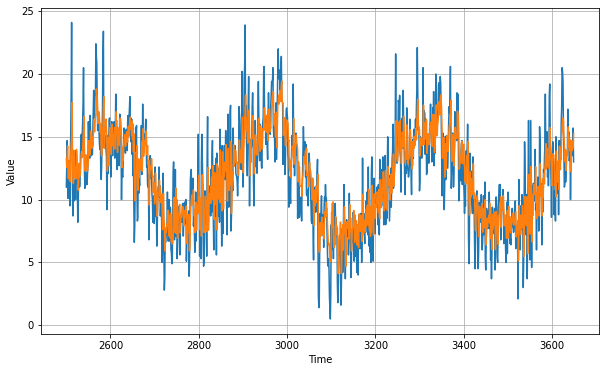

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7863394

In [24]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[13.275358 12.577495 13.56681  ... 14.271834 14.111617 15.270063]
